# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [96]:
import pandas as pd
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import math



## Cargar datos

In [97]:
users = pd.read_csv('/datasets/megaline_users.csv')

calls = pd.read_csv('/datasets/megaline_calls.csv')

messages = pd.read_csv('/datasets/megaline_messages.csv')

internet = pd.read_csv('/datasets/megaline_internet.csv')

plans = pd.read_csv('/datasets/megaline_plans.csv')


In [98]:
users.info()
users['reg_date'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


0    2018-12-24
1    2018-08-13
2    2018-10-21
3    2018-01-28
4    2018-05-23
Name: reg_date, dtype: object

In [99]:
calls.info()
calls['call_date'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


0    2018-12-27
1    2018-12-27
2    2018-12-27
3    2018-12-28
4    2018-12-30
Name: call_date, dtype: object

In [100]:
messages.info()
messages['message_date'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


0    2018-12-27
1    2018-12-31
2    2018-12-31
3    2018-12-27
4    2018-12-26
Name: message_date, dtype: object

In [101]:
internet.info()
internet['session_date'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


0    2018-12-29
1    2018-12-31
2    2018-12-28
3    2018-12-26
4    2018-12-27
Name: session_date, dtype: object

In [102]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


## Preparar los datos

<div class="alert alert-block alert-info">
**PLAN DE ACCIÓN**
    
1. Revisar que no haya valores duplicados ni ausentes. 
    
2. Cambiar los tipos de datos a formato de fechas (aplica para las bases de datos: 'users', 'calls', 'messages' e 'internet'.

## Tarifas

In [103]:
plans.info()
print()
plans.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
std,671.751442,10861.160159,1767.766953,35.355339,2.12132,0.014142,0.014142
min,50.000000,15360.000000,500.000000,20.000000,7.00000,0.010000,0.010000
25%,287.500000,19200.000000,1125.000000,32.500000,7.75000,0.015000,0.015000
50%,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
75%,762.500000,26880.000000,2375.000000,57.500000,9.25000,0.025000,0.025000
max,1000.000000,30720.000000,3000.000000,70.000000,10.00000,0.030000,0.030000


In [104]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


<div class="alert alert-block alert-info">
En el caso de esta base de datos, todo parece en orden, la información está completa, es clara y en el formato indicado para cada una de las columnas y los datos. No hay información duplicada ni ausente; por ende, no debe modificarse en ningún aspecto. 

## Corregir datos

In [105]:
plans['mb_per_month_included'] = plans['mb_per_month_included'] / 1024

plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


In [106]:
print(plans.columns)

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'plan_name'],
      dtype='object')


In [107]:
column_new ={
    'mb_per_month_included': 'gb_per_month_included'
    }

plans.rename(columns = column_new, inplace = True)

plans.head()

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Enriquecer los datos

<div class="alert alert-block alert-info">
No aplica.

## Usuarios/as

In [108]:
users.info()
print()
users.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB



user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [109]:
users.describe()

,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


In [110]:
users.sample(5)


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
265,1265,Alec,Henry,29,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-11-23,surf,NaN
213,1213,Carl,Newman,47,"San Diego-Chula Vista-Carlsbad, CA MSA",2018-11-25,ultimate,NaN
179,1179,Darcey,Baird,22,"Dallas-Fort Worth-Arlington, TX MSA",2018-04-27,surf,NaN
445,1445,Elodia,Donovan,71,"Dallas-Fort Worth-Arlington, TX MSA",2018-01-27,ultimate,NaN
68,1068,Marcel,Jimenez,47,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-29,surf,NaN


<div class="alert alert-block alert-info">
Hay valores ausentes en los datos de **churn_date**, sin embargo, esto no es negativo, ya que significa que los usuarios continúan con el servicio, quizá sería bueno reemplazarlo y pasar este dato al tipo fecha. 
    
Además, la columna de **reg_date** debería estar en formato de fecha. 

### Corregir los datos

In [111]:
print(type(users['reg_date']))

users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

<class 'pandas.core.series.Series'>


In [112]:
users.info()
users['reg_date'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


0   2018-12-24
1   2018-08-13
2   2018-10-21
3   2018-01-28
4   2018-05-23
Name: reg_date, dtype: datetime64[ns]

### Enriquecer los datos

In [113]:
users['churn_date'] = users['churn_date'].fillna('0000-00-00')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [114]:
users['month_reg'] = users['reg_date'].dt.month

users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month_reg
153,1153,Kathaleen,Crawford,30,"Bridgeport-Stamford-Norwalk, CT MSA",2018-06-19,surf,0000-00-00,6
109,1109,Dominic,Salinas,41,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-16,surf,0000-00-00,2
141,1141,Kirstie,Hodges,46,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-26,surf,0000-00-00,6
387,1387,Raymonde,Lowe,28,"Bridgeport-Stamford-Norwalk, CT MSA",2018-05-25,surf,0000-00-00,5
116,1116,Moriah,Yates,60,"Cincinnati, OH-KY-IN MSA",2018-08-08,surf,0000-00-00,8
443,1443,Genaro,Quinn,58,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-03-11,surf,0000-00-00,3
485,1485,Damion,Woodard,67,"Nashville-Davidson–Murfreesboro–Franklin, TN MSA",2018-08-21,surf,0000-00-00,8
335,1335,Gail,Coleman,61,"Dallas-Fort Worth-Arlington, TX MSA",2018-06-02,surf,0000-00-00,6
283,1283,Alan,Burgess,38,"Charleston-North Charleston, SC MSA",2018-06-16,ultimate,0000-00-00,6
193,1193,Lacresha,Olsen,18,"Houston-The Woodlands-Sugar Land, TX MSA",2018-07-07,surf,0000-00-00,7


## Llamadas

In [115]:
calls.info()
print()
calls.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB



id           0
user_id      0
call_date    0
duration     0
dtype: int64

In [116]:
calls.describe()

,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


In [117]:
calls.sample(5)

,id,user_id,call_date,duration
53441,1192_184,1192,2018-12-27,10.94
92987,1334_355,1334,2018-09-22,0.00
96643,1345_53,1345,2018-12-24,13.30
128594,1462_7,1462,2018-10-31,6.91
108480,1382_1889,1382,2018-12-29,10.70


### Corregir los datos

In [118]:
print(type(calls['call_date']))

calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

<class 'pandas.core.series.Series'>


In [119]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [120]:
column_calls ={
    'id': 'id_call'
    }

calls.rename(columns = column_calls, inplace = True)

calls.head()

,id_call,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


### Enriquecer los datos

In [121]:
calls['month'] = calls['call_date'].dt.month
calls.head()

,id_call,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,12
1,1000_145,1000,2018-12-27,13.66,12
2,1000_247,1000,2018-12-27,14.48,12
3,1000_309,1000,2018-12-28,5.76,12
4,1000_380,1000,2018-12-30,4.22,12


In [122]:
calls['duration'] = np.ceil(calls['duration'])

calls.head()

,id_call,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9.0,12
1,1000_145,1000,2018-12-27,14.0,12
2,1000_247,1000,2018-12-27,15.0,12
3,1000_309,1000,2018-12-28,6.0,12
4,1000_380,1000,2018-12-30,5.0,12


## Mensajes

In [123]:
messages.info()
print()
messages.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB



id              0
user_id         0
message_date    0
dtype: int64

In [124]:
messages.describe()

,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000


In [125]:
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


### Corregir los datos

In [126]:
print(type(messages['message_date']))

messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

<class 'pandas.core.series.Series'>


In [127]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [128]:
column_sms ={
    'id': 'id_sms'
    }

messages.rename(columns = column_sms, inplace = True)

messages.head()

,id_sms,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


### Enriquecer los datos

In [129]:
messages['month'] = messages['message_date'].dt.month
messages.sample(10)

,id_sms,user_id,message_date,month
345,1003_39,1003,2018-12-24,12
48145,1324_876,1324,2018-12-02,12
63855,1407_82,1407,2018-12-08,12
49880,1328_838,1328,2018-05-22,5
12856,1084_96,1084,2018-11-02,11
3331,1036_166,1036,2018-08-10,8
1660,1017_0,1017,2018-10-12,10
52940,1339_74,1339,2018-10-18,10
44610,1298_66,1298,2018-12-25,12
48477,1326_14,1326,2018-10-10,10


## Internet

In [130]:
internet.info()
print()
internet.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB



id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

In [131]:
internet.describe()

,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


In [132]:
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


### Corregir los datos

In [133]:
print(type(internet['session_date']))

internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

<class 'pandas.core.series.Series'>


In [134]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [135]:
internet['mb_used'] = internet['mb_used'] / 1024

internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,0.087754
1,1000_204,1000,2018-12-31,0.000000
2,1000_379,1000,2018-12-28,0.644922
3,1000_413,1000,2018-12-26,0.264639
4,1000_442,1000,2018-12-27,0.859590


In [136]:
column_new_2 ={
    'mb_used': 'gb_used', 
    'id': 'id_session'
    }

internet.rename(columns = column_new_2, inplace = True)

internet.head()

,id_session,user_id,session_date,gb_used
0,1000_13,1000,2018-12-29,0.087754
1,1000_204,1000,2018-12-31,0.000000
2,1000_379,1000,2018-12-28,0.644922
3,1000_413,1000,2018-12-26,0.264639
4,1000_442,1000,2018-12-27,0.859590


### Enriquecer los datos

In [137]:
internet['month'] = internet['session_date'].dt.month
internet.sample(10)

,id_session,user_id,session_date,gb_used,month
36176,1163_157,1163,2018-11-02,0.444512,11
81086,1379_150,1379,2018-12-12,0.119424,12
2876,1016_40,1016,2018-12-11,0.630410,12
56145,1254_52,1254,2018-12-14,0.799111,12
36387,1164_70,1164,2018-07-09,0.463994,7
17246,1077_366,1077,2018-12-18,0.708857,12
50934,1228_29,1228,2018-12-08,0.193770,12
14849,1067_211,1067,2018-12-10,0.781650,12
47465,1212_159,1212,2018-12-07,0.000000,12
25224,1117_157,1117,2018-09-08,0.308203,9


## Estudiar las condiciones de las tarifas

In [138]:
plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


In [139]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls_by_month = calls.groupby(['user_id', 'month'])['id_call'].count().reset_index()

calls_by_month.head(10)

,user_id,month,id_call
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
5,1001,12,56
6,1002,10,11
7,1002,11,55
8,1002,12,47
9,1003,12,149


In [140]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutes_by_month = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
minutes_by_month.head(10)

,user_id,month,duration
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
5,1001,12,412.0
6,1002,10,59.0
7,1002,11,386.0
8,1002,12,384.0
9,1003,12,1104.0


In [141]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages_by_month = messages.groupby(['user_id', 'month'])['id_sms'].count().reset_index()
messages_by_month.tail(10)


,user_id,month,id_sms
1796,1494,9,21
1797,1494,10,38
1798,1494,11,35
1799,1494,12,33
1800,1496,8,2
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11
1805,1497,12,50


In [142]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet_by_month = internet.groupby(['user_id', 'month'])['gb_used'].sum().reset_index()
internet_by_month.head(10)


,user_id,month,gb_used
0,1000,12,1.856904
1,1001,8,6.756982
2,1001,9,13.002754
3,1001,10,21.807119
4,1001,11,18.070605
5,1001,12,18.915215
6,1002,10,6.398447
7,1002,11,18.891680
8,1002,12,14.058828
9,1003,12,26.410293


In [143]:
internet_by_month['gb_used'] = np.ceil(internet_by_month['gb_used'])
internet_by_month.head()

,user_id,month,gb_used
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0


In [144]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
df_1 = calls_by_month.merge(minutes_by_month,
                            on = ['user_id', 'month'], how = 'outer').merge(messages_by_month,
                            on = ['user_id', 'month'], how = 'outer').merge(internet_by_month,
                            on = ['user_id', 'month'], how = 'outer')
df_1.head(10)

,user_id,month,id_call,duration,id_sms,gb_used
0,1000,12,16.0,124.0,11.0,2.0
1,1001,8,27.0,182.0,30.0,7.0
2,1001,9,49.0,315.0,44.0,14.0
3,1001,10,65.0,393.0,53.0,22.0
4,1001,11,64.0,426.0,36.0,19.0
5,1001,12,56.0,412.0,44.0,19.0
6,1002,10,11.0,59.0,15.0,7.0
7,1002,11,55.0,386.0,32.0,19.0
8,1002,12,47.0,384.0,41.0,15.0
9,1003,12,149.0,1104.0,50.0,27.0


In [145]:
df_2 = users.merge(plans, left_on = 'plan',
                             right_on = 'plan_name'
                             ).drop('plan_name', axis = 'columns')
df_2.sample(3)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month_reg,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
277,1171,Devin,Wilkinson,56,"Boston-Cambridge-Newton, MA-NH MSA",2018-01-27,surf,0000-00-00,1,50,15.0,500,20,10,0.03,0.03
188,1045,Barney,Ortega,20,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-10-15,surf,0000-00-00,10,50,15.0,500,20,10,0.03,0.03
463,1439,Moses,Cabrera,28,"Riverside-San Bernardino-Ontario, CA MSA",2018-01-04,surf,0000-00-00,1,50,15.0,500,20,10,0.03,0.03


In [146]:
Megaline_df = df_1.merge(df_2, on = ['user_id'])
Megaline_df.head()

,user_id,month,id_call,duration,id_sms,gb_used,first_name,last_name,age,city,...,plan,churn_date,month_reg,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12,16.0,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,ultimate,0000-00-00,12,1000,30.0,3000,70,7,0.01,0.01
1,1001,8,27.0,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,surf,0000-00-00,8,50,15.0,500,20,10,0.03,0.03
2,1001,9,49.0,315.0,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,surf,0000-00-00,8,50,15.0,500,20,10,0.03,0.03
3,1001,10,65.0,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,surf,0000-00-00,8,50,15.0,500,20,10,0.03,0.03
4,1001,11,64.0,426.0,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,surf,0000-00-00,8,50,15.0,500,20,10,0.03,0.03


In [147]:
Megaline_df = Megaline_df.fillna(0)

Megaline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2293 non-null   int64         
 1   month                  2293 non-null   int64         
 2   id_call                2293 non-null   float64       
 3   duration               2293 non-null   float64       
 4   id_sms                 2293 non-null   float64       
 5   gb_used                2293 non-null   float64       
 6   first_name             2293 non-null   object        
 7   last_name              2293 non-null   object        
 8   age                    2293 non-null   int64         
 9   city                   2293 non-null   object        
 10  reg_date               2293 non-null   datetime64[ns]
 11  plan                   2293 non-null   object        
 12  churn_date             2293 non-null   object        
 13  mon

In [148]:
Megaline_df['info_sms'] = Megaline_df['id_sms'] - Megaline_df['messages_included'] 
Megaline_df['info_sms'] = Megaline_df['info_sms'].apply(lambda x:max (x,0))
Megaline_df['extra_income_sms'] = Megaline_df['info_sms'] * Megaline_df['usd_per_message']
Megaline_df['extra_income_sms'].sample(10)

918     0.0
784     0.0
577     0.0
567     0.0
612     0.0
743     0.0
1949    0.0
277     0.0
2287    0.0
1537    0.0
Name: extra_income_sms, dtype: float64

In [149]:
Megaline_df['info_calls'] = Megaline_df['duration'] - Megaline_df['minutes_included'] 
Megaline_df['info_calls'] = Megaline_df['info_calls'].apply(lambda x:max (x,0))
Megaline_df['extra_income_calls'] = Megaline_df['info_calls'] * Megaline_df['usd_per_minute']
Megaline_df['extra_income_calls'].sample(10)

1643    0.00
1906    0.00
70      0.00
2100    0.00
1827    0.00
815     0.00
426     0.00
266     8.82
1251    0.00
1873    0.00
Name: extra_income_calls, dtype: float64

In [150]:
Megaline_df['duration'].max()

1510.0

In [151]:
Megaline_df['info_internet'] = Megaline_df['gb_used'] - Megaline_df['gb_per_month_included'] 
Megaline_df['info_internet'] = Megaline_df['info_internet'].apply(lambda x:max (x,0))
Megaline_df['extra_income_internet'] = Megaline_df['info_internet'] * Megaline_df['usd_per_gb']
Megaline_df['extra_income_internet'].round(2).sample(10)

1831     0.0
157      0.0
1764     0.0
695      0.0
115      0.0
2091     0.0
855     60.0
2107     0.0
235     10.0
974      0.0
Name: extra_income_internet, dtype: float64

In [152]:
Megaline_df['gb_used'].max()

70.0

In [153]:
Megaline_df['total_income'] = Megaline_df['extra_income_sms'] + Megaline_df['extra_income_calls'] + Megaline_df['extra_income_internet'] + Megaline_df['usd_monthly_pay']

Megaline_df['total_income'].sample(10)

1632    210.00
377      55.49
2004     50.09
1461     99.14
1327     20.51
2062     70.00
1758     50.00
1245     70.00
408      70.00
923      70.00
Name: total_income, dtype: float64

In [154]:
Megaline_df

,user_id,month,id_call,duration,id_sms,gb_used,first_name,last_name,age,city,...,usd_per_gb,usd_per_message,usd_per_minute,info_sms,extra_income_sms,info_calls,extra_income_calls,info_internet,extra_income_internet,total_income
0,1000,12,16.0,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,7,0.01,0.01,0.0,0.00,0.0,0.0,0.0,0.0,70.00
1,1001,8,27.0,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,10,0.03,0.03,0.0,0.00,0.0,0.0,0.0,0.0,20.00
2,1001,9,49.0,315.0,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,10,0.03,0.03,0.0,0.00,0.0,0.0,0.0,0.0,20.00
3,1001,10,65.0,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,10,0.03,0.03,3.0,0.09,0.0,0.0,7.0,70.0,90.09
4,1001,11,64.0,426.0,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,10,0.03,0.03,0.0,0.00,0.0,0.0,4.0,40.0,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1204,12,0.0,0.0,78.0,36.0,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",...,7,0.01,0.01,0.0,0.00,0.0,0.0,6.0,42.0,112.00
2289,1349,10,0.0,0.0,76.0,13.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",...,10,0.03,0.03,26.0,0.78,0.0,0.0,0.0,0.0,20.78
2290,1349,11,0.0,0.0,72.0,17.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",...,10,0.03,0.03,22.0,0.66,0.0,0.0,2.0,20.0,40.66
2291,1349,12,0.0,0.0,61.0,13.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",...,10,0.03,0.03,11.0,0.33,0.0,0.0,0.0,0.0,20.33


## Estudia el comportamiento de usuario

### Llamadas

In [155]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
calls_duration_average = Megaline_df.groupby(['plan', 'month'])['duration'].mean().reset_index().sort_index()
calls_duration_average.round(2).sample(5)

,plan,month,duration
2,surf,3,330.00
20,ultimate,9,437.51
6,surf,7,449.98
4,surf,5,399.58
8,surf,9,414.23


Text(0, 0.5, 'Duration (minutes)')

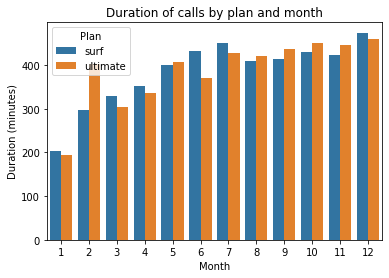

In [156]:
sns.barplot(x = 'month',
            y = 'duration', 
            hue = 'plan', 
            data = calls_duration_average
            )

plt.title('Duration of calls by plan and month')
plt.legend(title='Plan', loc='upper left')
plt.xlabel('Month')
plt.ylabel('Duration (minutes)')


Text(0, 0.5, 'Frequency')

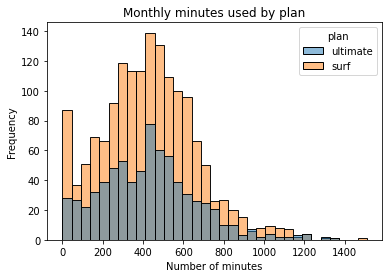

In [157]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
sns.histplot(data = Megaline_df, x = 'duration', hue = 'plan')

plt.title('Monthly minutes used by plan')
plt.xlabel('Number of minutes')
plt.ylabel('Frequency')

In [158]:
ultimate_info = Megaline_df[Megaline_df['plan'] == 'ultimate']
surf_info = Megaline_df[Megaline_df['plan'] == 'surf']

In [159]:
# Calcula la media y la varianza de la duración mensual de llamadas.
ultimate_mean = ultimate_info['duration'].mean()
ultimate_variance = np.var(ultimate_info['duration'])
print(f'Media del plan ultimate: {ultimate_mean.round(2)}')
print(f'Varianza del plan ultimate: {ultimate_variance.round(2)}')

Media del plan ultimate: 430.45
Varianza del plan ultimate: 57764.13


In [160]:
surf_mean = surf_info['duration'].mean()
surf_variance = np.var(surf_info['duration'])
print(f'Media del plan surf: {surf_mean.round(2)}')
print(f'Varianza del plan surf: {surf_variance.round(2)}')

Media del plan surf: 428.75
Varianza del plan surf: 54933.33


Text(0, 0.5, 'Duration')

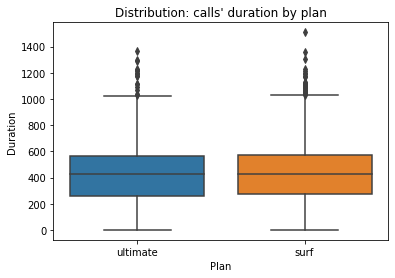

In [161]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
sns.boxplot(data = Megaline_df, x = 'plan', y = 'duration')

plt.title("Distribution: calls' duration by plan")
plt.xlabel('Plan')
plt.ylabel('Duration')

<div class="alert alert-block alert-info">
Gracias a los cálculos de la varianza y media de ambos planes podemos concluir que el comportamiento de los usuarios es muy similar entre sí, aunque estos cuenten con un plan de telefonía distinto. Además, esta conclusión se puede observar en el gráfico de bigotes, donde vemos dos cajas con valores muy similares entre sí, tanto de cuartiles, como media, dejando por fuera algunos valores atípicos que salen del rango. 

### Mensajes

In [162]:
# Compara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
montly_messages = Megaline_df.groupby(['plan', 'month'])['id_sms'].sum().reset_index().sort_index()
montly_messages.head()

,plan,month,id_sms
0,surf,1,21.0
1,surf,2,108.0
2,surf,3,351.0
3,surf,4,870.0
4,surf,5,1849.0


Text(0, 0.5, 'Number of messages')

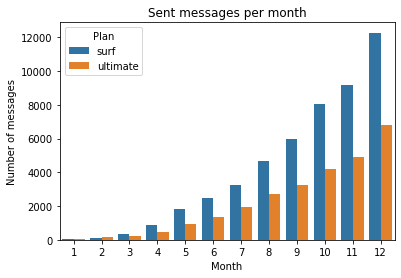

In [163]:
sns.barplot(x = 'month',
            y = 'id_sms', 
            hue = 'plan', 
            data = montly_messages
            )

plt.title('Sent messages per month')
plt.legend(title='Plan', loc='upper left')
plt.xlabel('Month')
plt.ylabel('Number of messages')

Text(0, 0.5, 'Frequency')

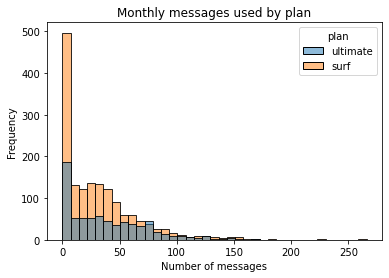

In [164]:
sns.histplot(data = Megaline_df, x = 'id_sms', hue = 'plan')

plt.title('Monthly messages used by plan')
plt.xlabel('Number of messages')
plt.ylabel('Frequency')

In [165]:
ultimate_sms_mean = ultimate_info['id_sms'].mean()
ultimate_sms_var = np.var(ultimate_info['id_sms'])
surf_sms_mean = surf_info['id_sms'].mean()
surf_sms_var = np.var(surf_info['id_sms'])

print(f'Media del plan ultimate: {ultimate_sms_mean.round(2)}')
print(f'Varianza del plan ultimate: {ultimate_sms_var.round(2)}')
print()
print(f'Media del plan surf: {surf_sms_mean.round(2)}')
print(f'Varianza del plan surf: {surf_sms_var.round(2)}')

Media del plan ultimate: 37.55
Varianza del plan ultimate: 1207.08

Media del plan surf: 31.16
Varianza del plan surf: 1126.01


Text(0, 0.5, 'Plan')

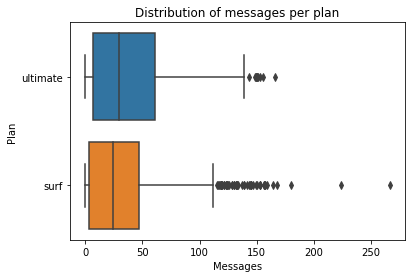

In [166]:
sns.boxplot(data = Megaline_df, x = 'id_sms', y = 'plan')

plt.title("Distribution of messages per plan")
plt.xlabel('Messages')
plt.ylabel('Plan')

<div class="alert alert-block alert-info">
Según la información analizada, sí hay una diferencia de comportamiento en el envío de mensajes según el plan que posea cada usuario. El plan ultimate contiene muchos más mensajes, parece más común que las personas con plan tipo surf envíen más mensajes que los otros usuarios durante gran parte del año; si bien la media de ultimate es más alta, es posible que esto se deba a la cantidad de usuarios que poseen surf y los que poseen ultimate, lo cual podría alterar este dato.

### Internet

In [167]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
internet_used_per_plan = Megaline_df.groupby(['plan', 'month'])['gb_used'].sum().reset_index().sort_index()
internet_used_per_plan.head()

,plan,month,gb_used
0,surf,1,10.0
1,surf,2,110.0
2,surf,3,312.0
3,surf,4,611.0
4,surf,5,1087.0


Text(0, 0.5, 'Gigabytes')

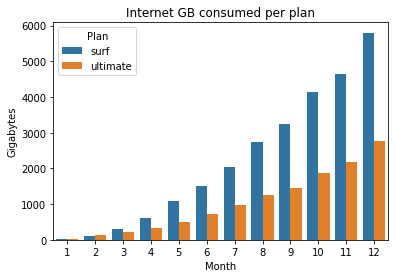

In [168]:
sns.barplot(x = 'month',
            y = 'gb_used',
            hue = 'plan', 
            data = internet_used_per_plan
             )

plt.title('Internet GB consumed per plan')
plt.legend(title='Plan', loc='upper left')
plt.xlabel('Month')
plt.ylabel('Gigabytes')

Text(0, 0.5, 'Frequency')

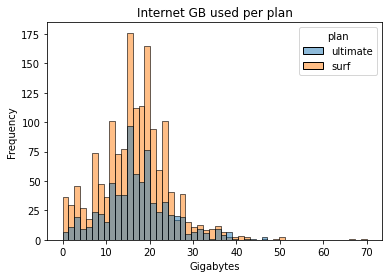

In [169]:
sns.histplot(data = Megaline_df, x = 'gb_used', hue = 'plan')
plt.title('Internet GB used per plan')
plt.xlabel('Gigabytes')
plt.ylabel('Frequency')

In [170]:
ultimate_gb_mean = ultimate_info['gb_used'].mean()
ultimate_gb_var = np.var(ultimate_info['gb_used'])
ultimate_gb_max = ultimate_info['gb_used'].max()
surf_gb_mean = surf_info['gb_used'].mean()
surf_gb_var = np.var(surf_info['gb_used'])
surf_gb_max = surf_info['gb_used'].max()

print(f'Media del plan ultimate: {ultimate_gb_mean.round(2)}')
print(f'Varianza del plan ultimate: {ultimate_gb_var.round(2)}')
print(f'Valor máximo de GB usadas en el plan ultimate: {ultimate_gb_max.round(2)}')
print()
print(f'Media del plan surf: {surf_gb_mean.round(2)}')
print(f'Varianza del plan surf: {surf_gb_var.round(2)}')
print(f'Valor máximo de GB usadas en el plan surf: {surf_gb_max.round(2)}')

Media del plan ultimate: 17.31
Varianza del plan ultimate: 58.75
Valor máximo de GB usadas en el plan ultimate: 46.0

Media del plan surf: 16.67
Varianza del plan surf: 61.54
Valor máximo de GB usadas en el plan surf: 70.0


Text(0, 0.5, 'Plan')

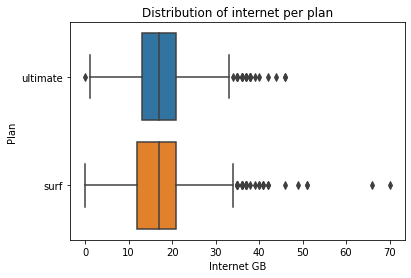

In [171]:
sns.boxplot(data = Megaline_df, x = 'gb_used', y = 'plan')

plt.title("Distribution of internet per plan")
plt.xlabel('Internet GB')
plt.ylabel('Plan')

<div class="alert alert-block alert-info">
Al igual que en el caso de las llamadas y los mensajes, el internet consumido por los usuarios de cada plan es similar y las diferencias no son muy pronunciadas; sin embargo, con el análisis y los gráficos podemos determinar los siguientes datos: 
    
- Los usuarios con plan surf, en general, usan en mayor cantidad los datos de internet.
    
- Los usuarios con plan ultimate, aun en su mayor consumo, no superan los consumos más altos de GB del plan surf.
   

## Ingreso

In [172]:
extra_income_df = Megaline_df[['plan', 'extra_income_sms', 'extra_income_calls',
                         'extra_income_internet']]

extra_income_df.round(2).head()

,plan,extra_income_sms,extra_income_calls,extra_income_internet
0,ultimate,0.00,0.0,0.0
1,surf,0.00,0.0,0.0
2,surf,0.00,0.0,0.0
3,surf,0.09,0.0,70.0
4,surf,0.00,0.0,40.0


In [173]:
income_df = Megaline_df[['plan', 'extra_income_sms', 'extra_income_calls',
                         'extra_income_internet', 'usd_monthly_pay', 
                         'total_income']]

income_df.round(2).head()

,plan,extra_income_sms,extra_income_calls,extra_income_internet,usd_monthly_pay,total_income
0,ultimate,0.00,0.0,0.0,70,70.00
1,surf,0.00,0.0,0.0,20,20.00
2,surf,0.00,0.0,0.0,20,20.00
3,surf,0.09,0.0,70.0,20,90.09
4,surf,0.00,0.0,40.0,20,60.00


In [174]:
income_df.describe()

,extra_income_sms,extra_income_calls,extra_income_internet,usd_monthly_pay,total_income
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,0.144322,1.264828,27.242041,35.699956,64.351147
std,0.493515,3.233992,48.571724,23.210863,46.624945
min,0.000000,0.000000,0.000000,20.000000,20.000000
25%,0.000000,0.000000,0.000000,20.000000,23.480000
50%,0.000000,0.000000,0.000000,20.000000,70.000000
75%,0.000000,0.000000,40.000000,70.000000,70.000000
max,6.480000,30.300000,550.000000,70.000000,590.370000


In [175]:
income_df[income_df['total_income'] == 590.370000]

,plan,extra_income_sms,extra_income_calls,extra_income_internet,usd_monthly_pay,total_income
1726,surf,2.28,18.09,550.0,20,590.37


In [176]:
users_plan_surf = Megaline_df.query("plan == 'surf'")['plan'].count()
income_plan_surf = Megaline_df.query("plan == 'surf'")['total_income'].sum()

print(f'Number of users with surf/plan: {users_plan_surf}')
print()
print(f"Megaline's anual income surf/plan: {income_plan_surf.round(2)}")

Number of users with surf/plan: 1573

Megaline's anual income surf/plan: 95491.18


In [177]:
users_plan_ultimate = Megaline_df.query("plan == 'ultimate'")['plan'].count()
income_plan_ultimate = Megaline_df.query("plan == 'ultimate'")['total_income'].sum()

print(f'Number of users with ultimate/plan: {users_plan_ultimate}')
print()
print(f"Megaline's anual income ultimate/plan: {income_plan_ultimate.round(2)}")

Number of users with ultimate/plan: 720

Megaline's anual income ultimate/plan: 52066.0


Text(0.5, 0, 'USD')

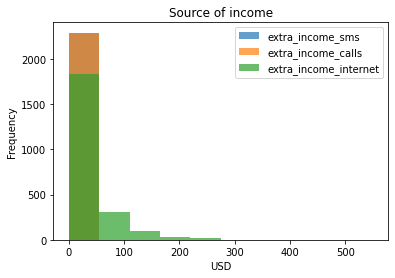

In [179]:
extra_income_df.plot(kind = 'hist', alpha = 0.7)

plt.title('Source of income')
plt.xlabel('USD')

In [180]:
variance = np.var(income_df['total_income'])
print(f'Varianza del ingreso total: {variance.round(2)}')

Varianza del ingreso total: 2172.94


Text(0, 0.5, 'Plan')

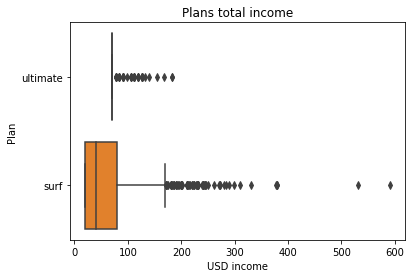

In [181]:
sns.boxplot(data = income_df, x = 'total_income', y = 'plan')

plt.title("Plans total income")
plt.xlabel('USD income')
plt.ylabel('Plan')

<div class="alert alert-block alert-info">
En esta sección existen varios datos de los ingresos por plan, estas son algunas de las conclusiones que se pueden extraer: 
    
- Los ingresos extra más significativos son los provenientes de GB de internet adicionales.
    
- Los ingresos extra menos significativos provienen del consumo adicional de mensajes. 
    
- Son más los usuarios que prefieren pagar el plan surf, en una relación de 1573 a 720, generando casi el doble de ingresos que en el plan ultimate. 
    
- Es mucho más común que los usuarios con un plan surf sobrepasen los límites de su plan, esto se evidencia en la gráfica de caja, donde todos los cuartiles de ultimate se concentra en la media de 70 dólares y solo hay puntos, o usuarios, aislados que sobrepasan su tarifa (en menor cantidad a comparación del plan surf).
    

## Prueba las hipótesis estadísticas

Ho = Los ingresos promedio de ambos planes son iguales

H1 = Los ingresos promedio de ambos planes son diferentes

In [182]:
income_plan_df = Megaline_df[['plan','total_income']]

ultimate_income_mean = Megaline_df.query("plan == 'ultimate'")['total_income'].mean()

surf_income_mean = Megaline_df.query("plan == 'surf'")['total_income'].mean()

income_plan_df.round(2).sample(5)
print()
print(f'Media de los ingresos del plan ultimate: {ultimate_income_mean.round(2)}')
print(f'Media de los ingresos del plan surf: {surf_income_mean.round(2)}')


Media de los ingresos del plan ultimate: 72.31
Media de los ingresos del plan surf: 60.71


In [183]:
ultimate_income = Megaline_df.query("plan == 'ultimate'")['total_income']

surf_income = Megaline_df.query("plan == 'surf'")['total_income']

In [184]:
print(ultimate_income.var())
print()
print(surf_income.var())

129.8484855509195

3067.835152293878


In [185]:
st.levene(ultimate_income, surf_income, center='median', proportiontocut = 0.05)

LeveneResult(statistic=404.7301727752691, pvalue=5.028876110654919e-83)

In [186]:
# Prueba las hipótesis
alpha = 0.05

results = st.ttest_ind(ultimate_income.dropna(), surf_income.dropna(), equal_var = False) 

print('valor-p:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor-p: 3.17039054811355e-15
Rechazamos la hipótesis nula


Ho = Los ingresos promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones

H1 = Los ingresos promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones

In [187]:
NY_NJ_users_mean = Megaline_df.query("city == 'New York-Newark-Jersey City, NY-NJ-PA MSA'")['total_income'].mean()
other_city_users_mean = Megaline_df.query("city != 'New York-Newark-Jersey City, NY-NJ-PA MSA'")['total_income'].mean()
print(f'Ingreso promedio de los usuarios en el área NY-NJ: {NY_NJ_users_mean.round(2)}')
print(f'Ingreso promedio de los usuarios de otras áreas: {other_city_users_mean.round(2)}')

Ingreso promedio de los usuarios en el área NY-NJ: 59.92
Ingreso promedio de los usuarios de otras áreas: 65.22


In [188]:
NY_NJ_users = Megaline_df.query("city == 'New York-Newark-Jersey City, NY-NJ-PA MSA'")['total_income']

other_city_users = Megaline_df.query("city != 'New York-Newark-Jersey City, NY-NJ-PA MSA'")['total_income']

In [189]:
print(NY_NJ_users.var())

print(other_city_users.var())

1895.5456899204246
2225.0479943518917


In [190]:
st.levene(NY_NJ_users, NY_NJ_users, center='median', proportiontocut = 0.05)

LeveneResult(statistic=0.0, pvalue=1.0)

In [191]:
# Prueba las hipótesis
NY_NJ_users = Megaline_df.query("city == 'New York-Newark-Jersey City, NY-NJ-PA MSA'")['total_income']

other_city_users = Megaline_df.query("city != 'New York-Newark-Jersey City, NY-NJ-PA MSA'")['total_income']

alpha = 0.05

results_2 = st.ttest_ind(NY_NJ_users, other_city_users, equal_var = False)

print('valor-p:', results_2.pvalue)

if (results.pvalue) < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")



valor-p: 0.03352561588530014
Rechazamos la hipótesis nula


## Conclusión general



<div class="alert alert-block alert-info">
Tras el preprocesamiento de datos y el análisis consiguiente, estas son algunas de las conclusiones más notables:
    
- El comportamiento y consumo de los usuarios es diferente entre sí.
    
-  Existe una diferencia de comportamiento en el envío de mensajes según el plan que posea cada usuario. Si bien el plan ultimate contiene muchos más mensajes, parece más común que las personas con plan tipo surf envíen sms en mayor cantidad; no obstante, la diferencia no es tan significativa en cuanto a la media, es posible que esto se deba a la cantidad de usuarios que poseen surf y los que poseen ultimate, el cual podría alterar la cantidad de mensajes enviados por mes.
    
- El internet consumido por los usuarios de cada plan es diferente entre sí, siendo casi el doble el consumo del plan surf que el del plan ultimate; con el análisis y los gráficos podemos determinar los siguientes datos: 
    - Los usuarios con plan surf, en general, usan en mayor cantidad los datos de internet.
    
    - Los usuarios con plan ultimate, aun en su mayor consumo, no superan los consumos más altos de GB del plan surf.
   
- Los ingresos adicioneles para Megaline llegan, en mayor medida, gracias al consumo de GB de internet adicionales. 
    
- Los ingresos extra menos significativos provienen del consumo adicional de mensajes. 
    
- Son más los usuarios que prefieren pagar el plan surf, en una relación de 1573 a 720, generando más del triple de ingresos que en el plan ultimate.
    
- Es más común que los usuarios con un plan surf sobrepasen los límites de su plan.
    
- El mayor consumo de los usuarios del plan ultimate, en comparación con los de surf, es en el rubro de uso de minutos y duración de las llamadas.
    
**Hipótesis de ingresos por plan y por ciudad**
- Según la información, los ingresos promedio de cada plan son muy diferentes entre sí, siendo mucho mayor el del plan surf. Por ende, rechazamos la hipótesis nula.
    
- El consumo general de los planes de telefonía en New York y New Jersey (incluyendo a Newark) son diferentes a los de las otras ciudades, viendo las cifras, el promedio de ingresos de estas tres regiones es menor que el de las demás ciudades, pal igual que el ingreso general, las demás ciudades siguen generando mayores ingresos, no por ello debe desestimarse la zona antes mencionada, ya que la diferencia no es muy grande. Definitivament, New York, New Jersey y Newark son una gran zona para ventas.
    
**Conclusiones generales para el equipo de Marketing**
- El plan surf genera mayores ingresos, en especial porque los usuarios que lo implementan terminan pagando por más internet y más minutos. Lo cierto es que el valor mensual del plan surf parece ser mucho más atractivo para los usuarios, es por ello que se recomienda invertir más en la promoción del plan ultimate, como el plan surf se vende por si solo, asegurar más usuarios en ultimate podría llegar a ser más beneficioso en el aprovechamiento de recursos del departamento.